In [136]:
#Clare McMullen
#Used Car Predictions
#20121629

In [137]:
#Connecting to my Google Drive to get the files
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [138]:
import pandas as pd
from pandas import Series
from sklearn.model_selection import train_test_split
import datetime

#Importing the Dataset
cardata = pd.read_csv('/content/gdrive/MyDrive/cardata.csv', engine='python')


In [139]:
#making the date column a datetime type
cardata['posting_date'] = cardata['posting_date'].apply(lambda x: str(x)[:19])
cardata['posting_date'] = cardata['posting_date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%dT%H:%M:%S'))


In [140]:
#making a new column days to use instead of date
#instead int number of days since post
today = '2021-4-17T21:00:00'
today = datetime.datetime.strptime(today, '%Y-%m-%dT%H:%M:%S')
cardata['days'] = cardata['posting_date'].apply(lambda x: (today - x).days)


In [141]:
#restrict cars to only be in these four states (close to the border)
cardata = cardata.loc[cardata['state'].isin(['ny','mi','nh','vt'])]

#restrict cars only to be later than 2009
cardata = cardata.loc[cardata['year']>2009]
cardata

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date,days
18034,7240611333,https://annarbor.craigslist.org/cto/d/ann-arbo...,ann arbor,https://annarbor.craigslist.org,5500,2011.0,volkswagen,tiguan,good,4 cylinders,gas,127401.0,clean,automatic,WVGBV7AX7BW000362,4wd,compact,hatchback,red,https://images.craigslist.org/00N0N_cejYvFWkPE...,2011 VW Tiguan S 4-Motion Looks Good and Runs ...,mi,42.269400,-83.728200,2020-12-02 15:17:08,136
18035,7240580221,https://annarbor.craigslist.org/ctd/d/utica-20...,ann arbor,https://annarbor.craigslist.org,14995,2014.0,volkswagen,jetta sedan,excellent,4 cylinders,diesel,21596.0,clean,automatic,3VWLL7AJ9EM381708,fwd,compact,sedan,black,https://images.craigslist.org/00K0K_1BouoTUMmC...,2014 Volkswagen Jetta Sedan 4dr DSG TDI - Blac...,mi,42.591420,-83.031000,2020-12-02 14:31:17,136
18036,7240577301,https://annarbor.craigslist.org/cto/d/brighton...,ann arbor,https://annarbor.craigslist.org,21575,2017.0,gmc,acadia slt awd,like new,6 cylinders,gas,68600.0,clean,automatic,1GKKNULS5HZ127255,4wd,mid-size,SUV,red,https://images.craigslist.org/00A0A_1BnqnMJD73...,2017 GMC Acadia AWD (4x4) SLT GPS NAVIGATION 8...,mi,42.537100,-83.775600,2020-12-02 14:26:38,136
18037,7240544212,https://annarbor.craigslist.org/ctd/d/utica-20...,ann arbor,https://annarbor.craigslist.org,14500,2013.0,volkswagen,passat,excellent,4 cylinders,diesel,64947.0,clean,automatic,1VWBN7A37DC034188,fwd,mid-size,sedan,black,https://images.craigslist.org/00o0o_cjo4HUt84w...,2013 Volkswagen Passat 4dr Sdn 2.0L DSG TDI SE...,mi,42.591420,-83.031000,2020-12-02 13:36:30,136
18038,7240434371,https://annarbor.craigslist.org/cto/d/ypsilant...,ann arbor,https://annarbor.craigslist.org,26900,2020.0,chrysler,pacifica touring l,like new,6 cylinders,gas,16200.0,clean,automatic,2C4RC1BG1LR125582,fwd,full-size,van,grey,https://images.craigslist.org/01414_heu6sCb0Yi...,Beautiful van in like new condition. Lots of o...,mi,42.252400,-83.634000,2020-12-02 11:01:11,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42148,7240636594,https://utica.craigslist.org/ctd/d/oriskany-20...,utica-rome-oneida,https://utica.craigslist.org,22500,2013.0,ford,f-350 sd,good,8 cylinders,gas,106589.0,clean,automatic,1FT8W3B68DEB11084,4wd,full-size,truck,white,https://images.craigslist.org/00101_hjOnPArUbL...,"2013 Ford F-350 SD XLT Crew Cab 4WD - $22,500 ...",ny,43.162643,-75.417513,2020-12-02 15:55:34,136
42152,7240984708,https://nh.craigslist.org/cto/d/nashua-2011-mi...,new hampshire,https://nh.craigslist.org,6200,2011.0,mini,cooper clubman,good,4 cylinders,gas,70652.0,clean,manual,WMWZF3C54BTX82283,fwd,compact,wagon,white,https://images.craigslist.org/00m0m_lhHK2GfCG2...,2011 Mini Cooper Clubman 3-Door Wagon. Pepper ...,nh,42.702400,-71.477100,2020-12-03 10:40:22,135
42154,7240939543,https://nh.craigslist.org/cto/d/alton-2019-jee...,new hampshire,https://nh.craigslist.org,20800,2019.0,jeep,compass trailhawk,like new,4 cylinders,gas,12400.0,clean,automatic,3C4NJDDB1KT712979,4wd,mid-size,SUV,silver,https://images.craigslist.org/00v0v_7NasDrQmYR...,For sale is a 2019 Jeep Compass with the Trail...,nh,43.463000,-71.229700,2020-12-03 09:19:16,135
42155,7240906582,https://nh.craigslist.org/cto/d/candia-2013-ho...,new hampshire,https://nh.craigslist.org,6000,2013.0,honda,civic,good,4 cylinders,gas,165000.0,clean,automatic,2HGFB2F56DH524730,fwd,compact,sedan,black,https://images.craigslist.org/00c0c_68djulEv2E...,2013 Honda Civic with 165k miles. Commuter ca...,nh,43.058500,-71.304900,2020-12-03 07:47:34,135


In [142]:
#dropping the unneeded features
features = cardata.drop(columns=['price', 'VIN', 'url', 'id', 'region_url','description', 'image_url', 'lat','long','posting_date', 'days','region','state'])

#set the target column to be price
target = cardata[['price']]

#split the training and testing data with a 20% test size
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)


In [143]:
# Model Training and Tuning

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

#This initializes a state so that we may recreate the same model each time we rerun.
np.random.seed(0)

#Here we create a list called numeric_features that contains the column names of the two numeric features
#then we create a pipeline of transformations for the numeric data
#first, SimpleImputer takes the missing values and replaces them with the median
#then the StandardScaler standardizes the data, subtracting the mean and scaling to unit variance

numeric_features = ['year','odometer']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Here we create a list called categorical_features that contains the column names of the many categorical featurs
#then we create a pipeline of transformations for the categorical data
#first, SimpleImputer takes the missing values and replaces them with the fill_value that is a string 'missing'
#then the OneHotEncoder creates binary columns for each categorial column label
categorical_features = ['model','manufacturer','condition', 'size', 'drive','type', 'paint_color','cylinders','fuel','title_status','transmission']
    
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


#the transformer performs the pipeline transformation initiated above to the numeric and categorical columns listed in numeric_feature and categorical_features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#this pipeline first runs the preprocessor transformations defined above, then runs the RandomForestRegressor 
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor())])

#make the training and testing sets have the numeric and categorical features we want
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

# set the parameters for the preprocessor and the regressor
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [100,200],
    'regressor__max_depth':[20, 100]
}

#perform grid search within the ranges specified above 
grid_search = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2)
grid_search.fit(X_train, y_train)

#this is the model
regr = grid_search.best_estimator_


print("Training accuracy: %0.4f" % regr.score(X_train, y_train))
print("Testing accuracy: %0.4f" % regr.score(X_test, y_test))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Training accuracy: 0.9784
Testing accuracy: 0.8776


In [144]:
#Display Feature Importances

from matplotlib import pyplot as plt
import eli5

#get the one hot encoder
onehote = (regr.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'])

#retrieve the names from the one hot encoder
onehotnames = onehote.get_feature_names(input_features=categorical_features)

all_names = np.r_[onehotnames, numeric_features]

#using eli5 to display
eli5.explain_weights(regr.named_steps['regressor'], top=50, feature_names=all_names)


Weight,Feature
0.2743 ± 0.0498,model_1500
0.1291 ± 0.0488,model_1500 4x4 st
0.1180 ± 0.1743,cylinders_6 cylinders
0.1045 ± 0.1637,fuel_diesel
0.0932 ± 0.1588,type_wagon
0.0533 ± 0.0671,fuel_gas
0.0224 ± 0.0541,cylinders_other
0.0207 ± 0.0169,type_SUV
0.0205 ± 0.0422,model_wrx
0.0143 ± 0.0337,fuel_other


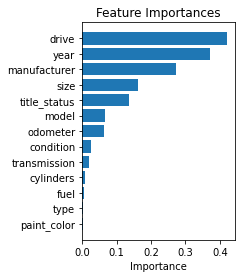

In [145]:
#Plot Permutation Importance

from sklearn.inspection import permutation_importance
from matplotlib import pyplot

#get the permutation importances using the training data (from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)
results = permutation_importance(regr, X_train, y_train, n_repeats=10,random_state=42)

#get the list of mean importances
importance = results.importances_mean

#sort the permutation importance and get the indexes 
perm_sorted_idx = results.importances_mean.argsort()

#graph it in a bar chart
pos = np.arange(perm_sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, importance[perm_sorted_idx], align='center')
plt.yticks(pos, np.array(list(features))[perm_sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()



In [148]:
#Make Predictions

#import the file from my google drive
pred_data = pd.read_csv('/content/gdrive/MyDrive/prediction_data.csv', engine='python', header = 0)
#drop the unneeded features
pfeatures = pred_data.drop(columns=['price', 'VIN', 'url', 'region_url','description', 'image_url', 'lat','long','posting_date', 'days','region', 'state'])
#make the predictions
predictions = regr.predict(pfeatures)
prices = pred_data['price']

#print the prediction vs original
#when the model is rerun the predictions change, so may be slightly different from my results section but very close.
print("Price", "     ", "Prediction")
for i in range(0,len(pred_data)):
  print(pred_data.price[i], " ", predictions[i]*1.25)

Price       Prediction
22888   19232.599899030152
9990   10579.67370772698
18593   22947.307504922166


/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
